# Unit 3: Lesson 4: Project 4 Challenge: SVM Regression and Classifier Challenge

The epicurious dataset has a collection of recipes, key terms, ingredients, and ratings.

## Objective: SVM to predict recipe review rating using key terms and ingredients
- create binary classifier to predict high and low ratings
- select 30 features (out of over 600 features in original dataset)
- explore ability to predict more classifiers (ratings between 0 - 5)
- predict high and low ratings based on selected features


#### Use SVR to determine initial accuracy of predictions:
- Accuracy is low with all initial features
- Attempting to run SVM with all features VERY time consuming

#### Select Features:
- Initially, tried to identify features by calculating percentages of features present and remove fewest represented features so only most represented features comprised remaining 30 features
- Struggled with ability to identify and select features that needed to be removed
- Settled on kselectbest to identify 30 best features as determined by F-score: __representing the ratio between the explained and the unexplained variance__

#### Prediction Accuracy:
- Initial feature selection resulted in equally poor accuracy with SVC on 6 classifiers: 0-5
- Initial kselectbest accuracy scores were just as poor on 6 classifiers: 0-5
- Second kselectbest accuracy scores were better using 2 classifiers for rating: high and low

#### Conclusion:
If additional attempts were to be made, would try reducing feature selection further.  F-scores on kselectbest drop notably after the first 8 features.

There appears to be significant bias.  It is intersting to note that 7 of 8 features belong to a similar category: alcoholic drinks.

[Kaggle Epicurious Data](https://www.kaggle.com/hugodarwood/epirecipes)

In [283]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import itertools
from itertools import chain
from itertools import accumulate

# for kselectbest
import sklearn.feature_selection as fs

# sklearn: import gridsearch to identify optimal lambda - regularization parameter by cross val
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVR
from sklearn.svm import SVC


## Load and Explore the dataset
We'll use the csv file here and as pull out column names and some summary statistics for ratings.

- just over 20,000 recipes with an average rating of 3.71
- the 25th percentile is actually above the mean. This means there is likely some kind of outlier population: some bad recipes may have very few and very low reviews.


In [284]:
raw_data = pd.read_csv('/Users/evarubin/Dev/thinkful/data/01-bootcamp-data/epi_r.csv')

In [285]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

### breakdown of reviews

- Histogram shows sharp discontinutities. No continuous data. No recipe has a 3.5 rating, for example. Lots of 0 reviews.


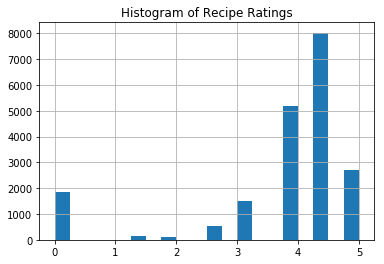

In [286]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

### Data Cleaning

- Since nutrition information is not available for all observations, drop the whole columns for calories, protein, fat, and sodium.

In [287]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

## Support Vector Regression
- takes a lot of time to run!

In [288]:
# Support Vector Regression
svr = SVR(gamma='auto')
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Scatter Plot

- useless visualization because data is discontinous nature of outcome variable.

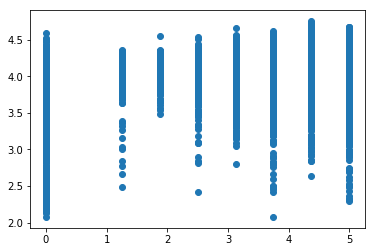

In [289]:
plt.scatter(Y, svr.predict(X));

### SVR Accuracy

Regression is very poor.  Overfit is problematic.

In [9]:
print('Accuracy Score for SVM Regression: ', svr.score(X, Y)

0.03856570651298896

In [290]:
# cross validation to check consistency of accuracy score using 5 random folds
cross_val_score(svr, X, Y, cv=5)

array([0.01818511, 0.026411  , 0.03037705, 0.01957949, 0.02451197])

Overfit is a problem using almost all of features originally included in data set.

Will leave nutrition data out.  Will identify and remove features least likely to contribute to prediction of classifiers.


In [14]:
raw_rating_counts = raw_data.groupby(
      ['rating']).agg({'rating': ['count']})

raw_rating_counts

,rating
,count
rating,
0.000,1836
1.250,164
1.875,124
2.500,532
3.125,1489
3.750,5169
4.375,8019
5.000,2719


In [6]:
# Combine ratings by whole number and create multiple classifiers
#float (str (w)[:-1])
#float (str (w)[:4] 

raw_data['rating_adjusted'] = raw_data['rating'].map('{:,.1f}'.format)

raw_data['rating_adjusted'] = raw_data['rating_adjusted'].str.replace(r'[^0-9]\d+', '')

raw_data['rating_adjusted'].head()

0    2
1    4
2    3
3    5
4    3
Name: rating_adjusted, dtype: object

In [7]:
# Get counts of adjusted ratings
adj_rating_counts = raw_data.groupby(
      ['rating_adjusted']).agg({'rating_adjusted': ['count']})

adj_rating_counts

,rating_adjusted
,count
rating_adjusted,
0,1836
1,288
2,532
3,6658
4,8019
5,2719


In [8]:
# Drop nutritional related features
df = raw_data.drop(['calories', 'protein', 'fat', 'sodium'], axis=1).dropna()

In [27]:
# See representation of features by classifiers
# https://stackoverflow.com/questions/47360510/pandas-groupby-and-aggregation-output-should-include-all-the-original-columns-i

g = df.groupby(['rating_adjusted'])
i = g.sum()

keyword_count = i.reset_index()
keyword_count


,rating_adjusted,rating,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,0,0.000,0.0,0.0,1.0,13.0,0.0,24.0,1.0,0.0,...,2.0,54.0,0.0,0.0,12.0,1.0,7.0,12.0,3.0,38.0
1,1,437.500,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,17.0,0.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0
2,2,1330.000,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1.0,14.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,8.0
3,3,24036.875,4.0,0.0,2.0,8.0,3.0,27.0,1.0,2.0,...,12.0,208.0,0.0,2.0,142.0,1.0,0.0,4.0,5.0,114.0
4,4,35083.125,1.0,0.0,9.0,2.0,2.0,29.0,0.0,0.0,...,8.0,181.0,0.0,3.0,108.0,1.0,0.0,7.0,6.0,192.0
5,5,13595.000,1.0,1.0,5.0,3.0,2.0,23.0,1.0,0.0,...,2.0,54.0,1.0,1.0,19.0,0.0,0.0,4.0,4.0,102.0


In [48]:
# Another look with a slightly different way
keyword_count2 = df.drop(['title'], axis=1).dropna()

keyword_count2 = df.agg("sum", axis="rows")

df_keyword_count_by_classifier = df.drop(['title'], axis=1).dropna()

df_keyword_count_by_classifier.groupby(
      ['rating_adjusted']).agg("sum", axis="rows")

,rating,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
rating_adjusted,,,,,,,,,,,,,,,,,,,,,
0,0.000,0.0,0.0,1.0,13.0,0.0,24.0,1.0,0.0,388.0,...,2.0,54.0,0.0,0.0,12.0,1.0,7.0,12.0,3.0,38.0
1,437.500,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,16.0,...,0.0,17.0,0.0,0.0,8.0,0.0,0.0,1.0,1.0,2.0
2,1330.000,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,21.0,...,1.0,14.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,8.0
3,24036.875,4.0,0.0,2.0,8.0,3.0,27.0,1.0,2.0,117.0,...,12.0,208.0,0.0,2.0,142.0,1.0,0.0,4.0,5.0,114.0
4,35083.125,1.0,0.0,9.0,2.0,2.0,29.0,0.0,0.0,103.0,...,8.0,181.0,0.0,3.0,108.0,1.0,0.0,7.0,6.0,192.0
5,13595.000,1.0,1.0,5.0,3.0,2.0,23.0,1.0,0.0,190.0,...,2.0,54.0,1.0,1.0,19.0,0.0,0.0,4.0,4.0,102.0


#### Prepare for identifying features with low importance in predicting classifiers
- warning: scary code ahead.  it doesn't work, but used it to identify poor features that are probably incorrect (continued on in order to reduce features in order to complete challenge.
- (don't worry: a better method appeared)

In [293]:

keywords = df[[
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisket',
 'broccoli',
 'broccoli rabe',
 'broil',
 'brooklyn',
 'brown rice',
 'brownie',
 'brunch',
 'brussel sprout',
 'buffalo',
 'buffet',
 'bulgaria',
 'bulgur',
 'burrito',
 'butter',
 'buttermilk',
 'butternut squash',
 'butterscotch/caramel',
 'cabbage',
 'cake',
 'california',
 'calvados',
 'cambridge',
 'campari',
 'camping',
 'canada',
 'candy',
 'candy thermometer',
 'cantaloupe',
 'capers',
 'caraway',
 'cardamom',
 'carrot',
 'cashew',
 'casserole/gratin',
 'cauliflower',
 'caviar',
 'celery',
 'chambord',
 'champagne',
 'chard',
 'chartreuse',
 'cheddar',
 'cheese',
 'cherry',
 'chestnut',
 'chicago',
 'chicken',
 'chickpea',
 'chile',
 'chile pepper',
 'chili',
 'chill',
 'chive',
 'chocolate',
 'christmas',
 'christmas eve',
 'cilantro',
 'cinco de mayo',
 'cinnamon',
 'citrus',
 'clam',
 'clove',
 'cobbler/crumble',
 'cocktail',
 'cocktail party',
 'coconut',
 'cod',
 'coffee',
 'coffee grinder',
 'cognac/armagnac',
 'collard greens',
 'colorado',
 'columbus',
 'condiment',
 'condiment/spread',
 'connecticut',
 'cook like a diner',
 'cookbook critic',
 'cookie',
 'cookies',
 'coriander',
 'corn',
 'cornmeal',
 'costa mesa',
 'cottage cheese',
 'couscous',
 'crab',
 'cranberry',
 'cranberry sauce',
 'cream cheese',
 'créme de cacao',
 'crêpe',
 'cr��me de cacao',
 'cuba',
 'cucumber',
 'cumin',
 'cupcake',
 'currant',
 'curry',
 'custard',
 'dairy',
 'dairy free',
 'dallas',
 'date',
 'deep-fry',
 'denver',
 'dessert',
 'digestif',
 'dill',
 'dinner',
 'dip',
 'diwali',
 'dominican republic',
 'dorie greenspan',
 'double boiler',
 'dried fruit',
 'drink',
 'drinks',
 'duck',
 'easter',
 'eau de vie',
 'edible gift',
 'egg',
 'egg nog',
 'eggplant',
 'egypt',
 'emeril lagasse',
 'endive',
 'engagement party',
 'england',
 'entertaining',
 'epi + ushg',
 'epi loves the microwave',
 'escarole',
 'fall',
 'family reunion',
 'fat free',
 "father's day",
 'fennel',
 'feta',
 'fig',
 'fish',
 'flaming hot summer',
 'flat bread',
 'florida',
 'fontina',
 'food processor',
 'fortified wine',
 'fourth of july',
 'france',
 'frangelico',
 'frankenrecipe',
 'freeze/chill',
 'freezer food',
 'friendsgiving',
 'frittata',
 'fritter',
 'frozen dessert',
 'fruit',
 'fruit juice',
 'fry',
 'game',
 'garlic',
 'georgia',
 'germany',
 'gin',
 'ginger',
 'goat cheese',
 'goose',
 'gouda',
 'gourmet',
 'graduation',
 'grains',
 'grand marnier',
 'granola',
 'grape',
 'grapefruit',
 'grappa',
 'green bean',
 'green onion/scallion',
 'grill',
 'grill/barbecue',
 'ground beef',
 'ground lamb',
 'guam',
 'guava',
 'haiti',
 'halibut',
 'halloween',
 'ham',
 'hamburger',
 'hanukkah',
 'harpercollins',
 'hawaii',
 'hazelnut',
 'healdsburg',
 'healthy',
 'herb',
 'high fiber',
 'hollywood',
 'hominy/cornmeal/masa',
 'honey',
 'honeydew',
 "hors d'oeuvre",
 'horseradish',
 'hot drink',
 'hot pepper',
 'house & garden',
 'house cocktail',
 'houston',
 'hummus',
 'ice cream',
 'ice cream machine',
 'iced coffee',
 'iced tea',
 'idaho',
 'illinois',
 'indiana',
 'iowa',
 'ireland',
 'israel',
 'italy',
 'jalapeño',
 'jam or jelly',
 'jamaica',
 'japan',
 'jerusalem artichoke',
 'juicer',
 'jícama',
 'kahlúa',
 'kale',
 'kansas',
 'kansas city',
 'kentucky',
 'kentucky derby',
 'kid-friendly',
 'kidney friendly',
 'kirsch',
 'kitchen olympics',
 'kiwi',
 'kosher',
 'kosher for passover',
 'kumquat',
 'kwanzaa',
 'labor day',
 'lamb',
 'lamb chop',
 'lamb shank',
 'lancaster',
 'las vegas',
 'lasagna',
 'leafy green',
 'leek',
 'legume',
 'lemon',
 'lemon juice',
 'lemongrass',
 'lentil',
 'lettuce',
 'lima bean',
 'lime',
 'lime juice',
 'lingonberry',
 'liqueur',
 'lobster',
 'london',
 'long beach',
 'los angeles',
 'louisiana',
 'louisville',
 'low cal',
 'low carb',
 'low cholesterol',
 'low fat',
 'low sodium',
 'low sugar',
 'low/no sugar',
 'lunar new year',
 'lunch',
 'lychee',
 'macadamia nut',
 'macaroni and cheese',
 'maine',
 'mandoline',
 'mango',
 'maple syrup',
 'mardi gras',
 'margarita',
 'marinade',
 'marinate',
 'marsala',
 'marscarpone',
 'marshmallow',
 'martini',
 'maryland',
 'massachusetts',
 'mayonnaise',
 'meat',
 'meatball',
 'meatloaf',
 'melon',
 'mexico',
 'mezcal',
 'miami',
 'michigan',
 'microwave',
 'midori',
 'milk/cream',
 'minneapolis',
 'minnesota',
 'mint',
 'mississippi',
 'missouri',
 'mixer',
 'molasses',
 'monterey jack',
 'mortar and pestle',
 "mother's day",
 'mozzarella',
 'muffin',
 'mushroom',
 'mussel',
 'mustard',
 'mustard greens',
 'nancy silverton',
 'nebraska',
 'nectarine',
 'new hampshire',
 'new jersey',
 'new mexico',
 'new orleans',
 "new year's day",
 "new year's eve",
 'new york',
 'no meat, no problem',
 'no sugar added',
 'no-cook',
 'non-alcoholic',
 'noodle',
 'north carolina',
 'nut',
 'nutmeg',
 'oat',
 'oatmeal',
 'octopus',
 'ohio',
 'oklahoma',
 'okra',
 'oktoberfest',
 'olive',
 'omelet',
 'one-pot meal',
 'onion',
 'orange',
 'orange juice',
 'oregano',
 'oregon',
 'organic',
 'orzo',
 'oscars',
 'oyster',
 'pacific palisades',
 'paleo',
 'pan-fry',
 'pancake',
 'papaya',
 'paprika',
 'parade',
 'paris',
 'parmesan',
 'parsley',
 'parsnip',
 'party',
 'pasadena',
 'passion fruit',
 'passover',
 'pasta',
 'pasta maker',
 'pastry',
 'pea',
 'peach',
 'peanut',
 'peanut butter',
 'peanut free',
 'pear',
 'pecan',
 'pennsylvania',
 'pepper',
 'pernod',
 'persian new year',
 'persimmon',
 'peru',
 'pescatarian',
 'philippines',
 'phyllo/puff pastry dough',
 'pickles',
 'picnic',
 'pie',
 'pine nut',
 'pineapple',
 'pistachio',
 'pittsburgh',
 'pizza',
 'plantain',
 'plum',
 'poach',
 'poblano',
 'poker/game night',
 'pomegranate',
 'pomegranate juice',
 'poppy',
 'pork',
 'pork chop',
 'pork rib',
 'pork tenderloin',
 'port',
 'portland',
 'pot pie',
 'potato',
 'potato salad',
 'potluck',
 'poultry',
 'poultry sausage',
 'pressure cooker',
 'prosciutto',
 'providence',
 'prune',
 'pumpkin',
 'punch',
 'purim',
 'quail',
 'quiche',
 'quick & easy',
 'quick and healthy',
 'quince',
 'quinoa',
 'rabbit',
 'rack of lamb',
 'radicchio',
 'radish',
 'raisin',
 'ramadan',
 'ramekin',
 'raspberry',
 'raw',
 'red wine',
 'rhode island',
 'rhubarb',
 'rice',
 'ricotta',
 'roast',
 'root vegetable',
 'rosemary',
 'rosh hashanah/yom kippur',
 'rosé',
 'rub',
 'rum',
 'rutabaga',
 'rye',
 'saffron',
 'sage',
 'sake',
 'salad',
 'salad dressing',
 'salmon',
 'salsa',
 'san francisco',
 'sandwich',
 'sandwich theory',
 'sangria',
 'santa monica',
 'sardine',
 'sauce',
 'sausage',
 'sauté',
 'scallop',
 'scotch',
 'seafood',
 'seattle',
 'seed',
 'self',
 'semolina',
 'sesame',
 'sesame oil',
 'shallot',
 'shavuot',
 'shellfish',
 'sherry',
 'shower',
 'shrimp',
 'side',
 'simmer',
 'skewer',
 'slow cooker',
 'smoker',
 'smoothie',
 'snapper',
 'sorbet',
 'soufflé/meringue',
 'soup/stew',
 'sour cream',
 'sourdough',
 'south carolina',
 'soy',
 'soy free',
 'soy sauce',
 'spain',
 'sparkling wine',
 'spice',
 'spinach',
 'spirit',
 'spring',
 'spritzer',
 'squash',
 'squid',
 'st. louis',
 "st. patrick's day",
 'steak',
 'steam',
 'stew',
 'stir-fry',
 'stock',
 'strawberry',
 'stuffing/dressing',
 'sugar conscious',
 'sugar snap pea',
 'sukkot',
 'summer',
 'super bowl',
 'suzanne goin',
 'sweet potato/yam',
 'swiss cheese',
 'switzerland',
 'swordfish',
 'taco',
 'tailgating',
 'tamarind',
 'tangerine',
 'tapioca',
 'tarragon',
 'tart',
 'tea',
 'tennessee',
 'tequila',
 'tested & improved',
 'texas',
 'thanksgiving',
 'thyme',
 'tilapia',
 'tofu',
 'tomatillo',
 'tomato',
 'tortillas',
 'tree nut',
 'tree nut free',
 'triple sec',
 'tropical fruit',
 'trout',
 'tuna',
 'turnip',
 'utah',
 "valentine's day",
 'vanilla',
 'veal',
 'vegan',
 'vegetable',
 'vegetarian',
 'venison',
 'vermont',
 'vermouth',
 'vinegar',
 'virginia',
 'vodka',
 'waffle',
 'walnut',
 'wasabi',
 'washington',
 'washington, d.c.',
 'watercress',
 'watermelon',
 'wedding',
 'weelicious',
 'west virginia',
 'westwood',
 'wheat/gluten-free',
 'whiskey',
 'white wine',
 'whole wheat',
 'wild rice',
 'windsor',
 'wine',
 'winter',
 'wisconsin',
 'wok',
 'yellow squash',
 'yogurt',
 'yonkers',
 'yuca',
 'zucchini',
 'cookbooks',
 'leftovers',
 'snack',
 'snack week',
 'turkey'
]]

#print(keywords)

#print(list_keywords)

for keyword in keywords:
    keyword_count = len(keywords)
    keyword_used_total = df[keyword].sum()
    keyword_used_total_percentage = "{:.2%}".format(keyword_used_total / len(df))
    
    #print(keyword, keyword_used_total, keyword_used_total_percentage)
    
    if keyword_used_total_percentage < "50.00":
        list_keywords_under_50_percent = []
        
        # keep adding the keywords to the list 
        list_keywords_under_50_percent.append(keyword)
        
        #list(chain.from_iterable(keyword))
        print(list_keywords_under_50_percent, keyword_used_total, keyword_used_total_percentage)
        
# #         dict_keywords_under_1_percent = {}
# #         dict_keywords_under_1_percent = {list_key_under_1_percent: keyword_used_total_percentage for list_key_under_1_percent in list_keywords_under_1_percent}


['#cakeweek'] 6.0 0.03%
['#wasteless'] 1.0 0.00%
['22-minute meals'] 17.0 0.08%
['3-ingredient recipes'] 27.0 0.13%
['30 days of groceries'] 7.0 0.03%
['advance prep required'] 109.0 0.54%
['alabama'] 3.0 0.01%
['alaska'] 2.0 0.01%
['alcoholic'] 835.0 4.16%
['almond'] 584.0 2.91%
['amaretto'] 39.0 0.19%
['anchovy'] 45.0 0.22%
['anise'] 116.0 0.58%
['anniversary'] 111.0 0.55%
['anthony bourdain'] 2.0 0.01%
['aperitif'] 12.0 0.06%
['apple'] 666.0 3.32%
['apple juice'] 6.0 0.03%
['apricot'] 269.0 1.34%
['arizona'] 8.0 0.04%
['artichoke'] 153.0 0.76%
['arugula'] 278.0 1.39%
['asian pear'] 20.0 0.10%
['asparagus'] 207.0 1.03%
['aspen'] 1.0 0.00%
['atlanta'] 7.0 0.03%
['australia'] 7.0 0.03%
['avocado'] 273.0 1.36%
['back to school'] 202.0 1.01%
['backyard bbq'] 938.0 4.68%
['bacon'] 587.0 2.93%
['bake'] 4413.0 22.01%
['banana'] 177.0 0.88%
['barley'] 50.0 0.25%
['basil'] 565.0 2.82%
['bass'] 90.0 0.45%
['bastille day'] 30.0 0.15%
['bean'] 577.0 2.88%
['beef'] 811.0 4.04%
['beef rib'] 56.0 0

['parmesan'] 644.0 3.21%
['parsley'] 514.0 2.56%
['parsnip'] 140.0 0.70%
['party'] 892.0 4.45%
['pasadena'] 12.0 0.06%
['passion fruit'] 44.0 0.22%
['passover'] 183.0 0.91%
['pasta'] 968.0 4.83%
['pasta maker'] 12.0 0.06%
['pastry'] 99.0 0.49%
['pea'] 211.0 1.05%
['peach'] 194.0 0.97%
['peanut'] 153.0 0.76%
['peanut butter'] 32.0 0.16%
['peanut free'] 8390.0 41.84%
['pear'] 279.0 1.39%
['pecan'] 331.0 1.65%
['pennsylvania'] 34.0 0.17%
['pepper'] 612.0 3.05%
['pernod'] 54.0 0.27%
['persian new year'] 4.0 0.02%
['persimmon'] 11.0 0.05%
['peru'] 2.0 0.01%
['pescatarian'] 6042.0 30.13%
['philippines'] 5.0 0.02%
['phyllo/puff pastry dough'] 126.0 0.63%
['pickles'] 16.0 0.08%
['picnic'] 519.0 2.59%
['pie'] 21.0 0.10%
['pine nut'] 228.0 1.14%
['pineapple'] 264.0 1.32%
['pistachio'] 176.0 0.88%
['pittsburgh'] 12.0 0.06%
['pizza'] 10.0 0.05%
['plantain'] 21.0 0.10%
['plum'] 114.0 0.57%
['poach'] 135.0 0.67%
['poblano'] 7.0 0.03%
['poker/game night'] 135.0 0.67%
['pomegranate'] 77.0 0.38%
['pome

In [294]:
# get rid of all columns that represent keywords that show up under 50% in observations 
# to reduce from 676 columns to 30

df_features_removed = df.drop(
['#cakeweek',
'#wasteless',
'22-minute meals',
'3-ingredient recipes',
'30 days of groceries',
'advance prep required',
'alabama',
'alaska',
'amaretto',
'anchovy',
'anise',
'anniversary',
'anthony bourdain',
'aperitif',
'apple juice',
'arizona',
'artichoke',
'asian pear',
'aspen',
'atlanta',
'australia',
'banana',
'barley',
'bass',
'bastille day',
'beef rib',
'beef shank',
'beef tenderloin',
'beer',
'beverly hills',
'birthday',
'biscuit',
'bitters',
'blackberry',
'blueberry',
'bok choy',
'bon app��tit',
'boston',
'bourbon',
'bran',
'breadcrumbs',
'brie',
'brine',
'brisket',
'broccoli',
'broccoli rabe',
'brooklyn',
'brown rice',
'brownie',
'brussel sprout',
'buffalo',
'buffet',
'bulgaria',
'bulgur',
'burrito',
'butter',
'buttermilk',
'butternut squash',
'butterscotch/caramel',
'california',
'calvados',
'cambridge',
'campari',
'camping',
'canada',
'candy',
'candy thermometer',
'cantaloupe',
'capers',
'caraway',
'cardamom',
'cashew',
'casserole/gratin',
'cauliflower',
'caviar',
'chambord',
'champagne',
'chard',
'chartreuse',
'chestnut',
'chicago',
'chickpea',
'chile',
'chili',
'cinco de mayo',
'clam',
'clove',
'cobbler/crumble',
'cod',
'coffee',
'coffee grinder',
'cognac/armagnac',
'collard greens',
'colorado',
'columbus',
'condiment',
'connecticut',
'cook like a diner',
'cookbook critic',
'cookie',
'coriander',
'costa mesa',
'cottage cheese',
'couscous',
'crab',
'cranberry sauce',
'créme de cacao',
'crêpe',
'cr��me de cacao',
'cuba',
'cumin',
'cupcake',
'currant',
'custard',
'dallas',
'date',
'deep-fry',
'denver',
'digestif',
'dip',
'diwali',
'dominican republic',
'dorie greenspan',
'double boiler',
'drinks',
'duck',
'eau de vie',
'edible gift',
'egg nog',
'egypt',
'emeril lagasse',
'endive',
'engagement party',
'england',
'entertaining',
'epi + ushg',
'epi loves the microwave',
'escarole',
'fig',
'flaming hot summer',
'flat bread',
'florida',
'fontina',
'fortified wine',
'france',
'frangelico',
'frankenrecipe',
'freezer food',
'friendsgiving',
'frittata',
'fritter',
'game',
'georgia',
'germany',
'goose',
'gouda',
'graduation',
'grains',
'grand marnier',
'granola',
'grape',
'grapefruit',
'grappa',
'green onion/scallion',
'ground beef',
'ground lamb',
'guam',
'guava',
'haiti',
'halibut',
'halloween',
'hamburger',
'hanukkah',
'harpercollins',
'hawaii',
'hazelnut',
'healdsburg',
'hollywood',
'hominy/cornmeal/masa',
'honeydew',
"hors d'oeuvre",
'horseradish',
'hot drink',
'house cocktail',
'houston',
'hummus',
'ice cream',
'ice cream machine',
'iced coffee',
'iced tea',
'idaho',
'illinois',
'indiana',
'iowa',
'ireland',
'israel',
'italy',
'jam or jelly',
'jamaica',
'japan',
'jerusalem artichoke',
'juicer',
'jícama',
'kahlúa',
'kale',
'kansas',
'kansas city',
'kentucky',
'kentucky derby',
'kirsch',
'kitchen olympics',
'kiwi',
'kosher for passover',
'kumquat',
'kwanzaa',
'labor day',
'lamb chop',
'lamb shank',
'lancaster',
'las vegas',
'lasagna',
'legume',
'lemon juice',
'lemongrass',
'lentil',
'lima bean',
'lime juice',
'lingonberry',
'lobster',
'london',
'long beach',
'los angeles',
'louisiana',
'louisville',
'low sugar',
'lunar new year',
'lychee',
'macadamia nut',
'macaroni and cheese',
'maine',
'mandoline',
'maple syrup',
'mardi gras',
'margarita',
'marinade',
'marsala',
'marscarpone',
'marshmallow',
'martini',
'maryland',
'massachusetts',
'meatball',
'meatloaf',
'melon',
'mexico',
'mezcal',
'miami',
'michigan',
'microwave',
'midori',
'minneapolis',
'minnesota',
'mississippi',
'missouri',
'molasses',
'monterey jack',
'mortar and pestle',
"mother's day",
'mozzarella',
'muffin',
'mussel',
'mustard greens',
'nancy silverton',
'nebraska',
'nectarine',
'new hampshire',
'new jersey',
'new mexico',
'new orleans',
"new year's day",
"new year's eve",
'new york',
'no meat, no problem',
'noodle',
'north carolina',
'nutmeg',
'oat',
'oatmeal',
'octopus',
'ohio',
'oklahoma',
'okra',
'oktoberfest',
'omelet',
'one-pot meal',
'orange juice',
'oregano',
'oregon',
'organic',
'orzo',
'oscars',
'oyster',
'pacific palisades',
'pancake',
'papaya',
'paprika',
'parade',
'paris',
'parsnip',
'pasadena',
'passion fruit',
'passover',
'pasta maker',
'pastry',
'peach',
'peanut',
#'peanut butter',
'pennsylvania',
'pernod',
'persian new year',
'persimmon',
'peru',
'philippines',
'phyllo/puff pastry dough',
'pickles',
'pie',
'pistachio',
'pittsburgh',
'pizza',
'plantain',
'plum',
'poach',
'poblano',
'poker/game night',
'pomegranate',
'pomegranate juice',
'poppy',
'pork chop',
'pork rib',
'pork tenderloin',
'port',
'portland',
'pot pie',
'potato salad',
'poultry sausage',
'pressure cooker',
'prosciutto',
'providence',
'prune',
'pumpkin',
'punch',
'purim',
'quail',
'quiche',
'quick and healthy',
'quince',
'quinoa',
'rabbit',
'rack of lamb',
'radicchio',
'ramadan',
'ramekin',
'raw',
'rhode island',
'rhubarb',
'ricotta',
'root vegetable',
'rosh hashanah/yom kippur',
'rosé',
'rub',
'rutabaga',
'rye',
'saffron',
'sage',
'sake',
'salad dressing',
'salsa',
'san francisco',
'sandwich theory',
'sangria',
'santa monica',
'sardine',
'scallop',
'scotch',
'seattle',
'seed',
'semolina',
'sesame',
'sesame oil',
'shavuot',
'sherry',
'skewer',
'slow cooker',
'smoker',
'smoothie',
'snapper',
'sorbet',
'soufflé/meringue',
'sourdough',
'south carolina',
'soy',
'spain',
'sparkling wine',
'spritzer',
'squash',
'squid',
'st. louis',
"st. patrick's day",
'stew',
'stock',
'stuffing/dressing',
'sugar snap pea',
'sukkot',
'suzanne goin',
'swiss cheese',
'switzerland',
'swordfish',
'taco',
'tailgating',
'tamarind',
'tangerine',
'tapioca',
'tart',
'tea',
'tennessee',
'tequila',
'tested & improved',
'texas',
'tilapia',
'tofu',
'tomatillo',
'tortillas',
'tree nut',
'triple sec',
'tropical fruit',
'trout',
'tuna',
'turnip',
'utah',
'veal',
'venison',
'vermont',
'vermouth',
'virginia',
'vodka',
'waffle',
'wasabi',
'washington',
'washington, d.c.',
'watercress',
'watermelon',
'wedding',
'weelicious',
'west virginia',
'westwood',
'whiskey',
'whole wheat',
'wild rice',
'windsor',
'wine',
'wisconsin',
'wok',
'yellow squash',
'yonkers',
'yuca',
'cookbooks',
'leftovers',
'snack',
'snack week',

 
'almond',
'apricot',
'arugula',
'asparagus',
'avocado',
'back to school',
'bacon',
'basil',
'bean',
'beet',
'berry',
'blue cheese',
'boil',
'braise',
'brandy',
'bread',
'broil',
'cabbage',
'celery',
'cheddar',
'cherry',
'chile pepper',
'chive',
'christmas eve',
'cinnamon',
'cocktail',
'coconut',
'cookies',
'corn',
'cornmeal',
'cranberry',
'cream cheese',
'cucumber',
'curry',
#'dairy free',
#'dessert',
'dill',
'dinner',
'dried fruit',
'easter',
'eggplant',
'fall',
'family reunion',
'fat free',
"father's day",
'fennel',
'feta',
'fourth of july',
'freeze/chill',
'frozen dessert',
'fruit juice',
'fry',
'gin',
'goat cheese',
'green bean',
'grill',
'ham',
'healthy',
'honey',
'hot pepper',
'house & garden',
'jalapeño',
'kidney friendly',
'lamb',
'leek',
'lettuce',
'lime',
'liqueur',
'low carb',
'low cholesterol',
'low sodium',
'low/no sugar',
'mango',
'mayonnaise',
'meat',
'mustard',
#'no sugar added',
'non-alcoholic',
'olive',
'onion',
'pan-fry',
'parsley',
'pea',
'pear',
'pecan',
'picnic',
'pine nut',
'pineapple',
'potluck',
'radish',
'raisin',
'raspberry',
'red wine',
'rice',
'rosemary',
'rum',
'salmon',
'sandwich',
'sausage',
'sauté',
'seafood',
'self',
'shallot',
'shellfish',
'shower',
'shrimp',
'side',
'sour cream',
'soy sauce',
'spinach',
'spirit',
'steak',
'steam',
'stir-fry',
'strawberry',
'sugar conscious',
'super bowl',
'sweet potato/yam',
'tarragon',
'thyme',
'tomato',
"valentine's day",
'vanilla',
'vegetable',
'walnut',
'white wine',
#'winter',
'yogurt',
'zucchini',
'turkey',
 
'apple',
'bake',
'bell pepper',
'blender',
'breakfast',
'cake',
'carrot',
'cilantro',
'marinate',
'mint',
'mixer',
'paleo',
'parmesan',
'pepper',
'poultry',
'quick & easy',
'spice',
'summer',
'vinegar',
 
'alcoholic',
'backyard bbq',
'beef',
'brunch',
'chocolate',
'citrus',
'condiment/spread',
'fish',
'food processor',
#'gourmet',
'kosher',
'leafy green',
'low fat',
'mushroom',
'nut',
'orange',
'party',
'pasta',
#'pescatarian',
'pork',
'simmer',
#'tree nut free',
'vegetarian',
 
'peanut free',
'soy free',
 
'chill',
'christmas',
'cocktail party',
'drink',
'ginger',
'grill/barbecue',
'high fiber',
'lemon',
'low cal',
'potato',
'sauce',
'soup/stew'

], 1)

# Check new df with features removed
df_features_removed.head()

,title,rating,appetizer,bon appétit,cheese,chicken,dairy,dairy free,dessert,egg,fruit,garlic,gourmet,herb,kid-friendly,lunch,milk/cream,no sugar added,no-cook,peanut butter,pescatarian,roast,salad,spring,thanksgiving,tree nut free,vegan,wheat/gluten-free,winter,rating_adjusted
0,"Lentil, Apple, and Turkey Wrap",2.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,Boudin Blanc Terrine with Red Onion Confit,4.375,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4
2,Potato and Fennel Soup Hodge,3.750,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,Mahi-Mahi in Tomato Olive Sauce,5.000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5
4,Spinach Noodle Casserole,3.125,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [249]:
# See all columns
pd.set_option('display.max_columns', 30)

# Group columns by review rating
df_features_removed.groupby(
      ['rating_adjusted']).agg("sum", axis="rows")

,title,rating,appetizer,bon appétit,cheese,chicken,dairy,dairy free,dessert,egg,fruit,garlic,gourmet,herb,kid-friendly,lunch,milk/cream,no sugar added,no-cook,peanut butter,pescatarian,roast,salad,spring,thanksgiving,tree nut free,vegan,wheat/gluten-free,winter
rating_adjusted,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Garlic Baguette Crumbs Pastry Twists with Spic...,0.000,80.0,556.0,50.0,63.0,71.0,241.0,281.0,121.0,116.0,97.0,365.0,71.0,238.0,104.0,131.0,167.0,84.0,10.0,394.0,42.0,91.0,102.0,92.0,422.0,212.0,372.0,138.0
1,Sweet Buttermilk Spoon Breads Avocado and Smok...,437.500,16.0,89.0,12.0,14.0,29.0,37.0,67.0,38.0,28.0,23.0,105.0,18.0,28.0,22.0,34.0,27.0,28.0,0.0,93.0,5.0,17.0,19.0,9.0,90.0,40.0,67.0,41.0
2,"Lentil, Apple, and Turkey Wrap Dried Pear Cris...",1330.000,43.0,194.0,40.0,28.0,48.0,118.0,106.0,44.0,58.0,32.0,196.0,41.0,51.0,34.0,52.0,91.0,38.0,1.0,175.0,21.0,42.0,38.0,20.0,194.0,81.0,153.0,75.0
3,Potato and Fennel Soup Hodge Spinach Noodle Ca...,24036.875,470.0,3022.0,476.0,558.0,498.0,1106.0,1067.0,618.0,620.0,576.0,2573.0,612.0,519.0,404.0,664.0,1132.0,475.0,6.0,2008.0,376.0,524.0,648.0,382.0,2337.0,641.0,1622.0,1144.0
4,Boudin Blanc Terrine with Red Onion Confit The...,35083.125,599.0,4206.0,653.0,574.0,657.0,1224.0,1486.0,726.0,887.0,703.0,2694.0,748.0,646.0,601.0,839.0,1321.0,483.0,8.0,2492.0,654.0,672.0,722.0,688.0,2963.0,610.0,1952.0,1368.0
5,Mahi-Mahi in Tomato Olive Sauce Mozzarella-Top...,13595.000,164.0,1288.0,124.0,107.0,193.0,480.0,566.0,221.0,249.0,212.0,715.0,191.0,309.0,194.0,275.0,394.0,143.0,7.0,880.0,222.0,170.0,186.0,267.0,1038.0,267.0,740.0,333.0


In [ ]:
# Office Hours Notes with Trello: Options for selecting features:
# SelectKBest(score_func=<function f_classif>, k=10)
# what I did - choose features based on percentages
# PCA - if every time a recipe has same ingredients, it will de-duplicate.
###for example, if recipe has sugar and it also has eggs, PCA will de-duplicate

In [251]:
# given data, will give best estimates for model

# SVC:
## C : strength of the penalty term in equation
## Gamma (for kernel inside model)
# gridsearchcv is basically a for loop, that scores and does cross validation
# here's the model i want to train: kernel = linear
# give it model and parameter, and it'll figure out which ones are best
# .fit runs model for every single configuration of grid and provides best parameters and best model
# you can have different svc's with different hyper-parameters

def svc_model_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1]
    #gammas = [0.01, 0.1, 1]
    param_grid = {'C': Cs}
    #param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_estimator_

## SVC Model using 6 classifiers on original reduced feature set - by percentage

In [258]:
X_svc_model_select_orig = df_features_removed.drop(['title', 'rating', 'rating_adjusted'], axis=1).dropna()

y_svc_model_select_orig = df_features_removed['rating_adjusted']

model_orig = svc_model_selection(X_svc_model_select_orig, y_svc_model_select_orig, 5)
model_orig

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [259]:
cross_val_score(model_orig, X_svc_model_select_orig, y_svc_model_select_orig, cv=5)

array([0.39870421, 0.40677966, 0.40164547, 0.39910202, 0.40054904])

## SVC Model by selecting features with kselectbest

In [266]:
# trying k selectbest
# https://stackoverflow.com/questions/49214001/what-do-these-f-scores-mean-using-selectkbest-feature
y_selectbest = df['rating_adjusted']
X_selectbest = df.drop(['title', 'rating', 'rating_adjusted'], axis=1).dropna()

selector = fs.SelectKBest(k=30)

selector.fit(X_selectbest, y_selectbest)
names = X_selectbest.columns.values[selector.get_support()]

scores = selector.scores_[selector.get_support()]

names_scores = list(zip(names, scores))

ns_df = pd.DataFrame(data = names_scores, columns=
                     ['Feature_names','F_Scores'])

ns_df_sorted = ns_df.sort_values(['F_Scores','Feature_names'], ascending =
  [False, True])

print(ns_df_sorted)

     Feature_names    F_Scores
9            drink  419.710152
0        alcoholic  358.000105
15  house & garden  247.107175
12             gin  207.357446
6         cocktail  145.991361
26          spirit  123.826781
7   cocktail party  110.635699
2          bitters  104.046967
3      bon appétit   73.646765
1             bake   64.524476
14   harpercollins   64.388475
24           sauté   62.980557
13         gourmet   60.818781
17         liqueur   58.230008
21    quick & easy   54.141686
28       vegetable   43.960332
20     peanut free   40.868570
10            fall   39.543653
19           pasta   39.335928
18   non-alcoholic   39.267131
5     chile pepper   38.972972
25        soy free   38.274754
23             rum   36.650481
8        condiment   30.435692
11     fruit juice   30.400728
16      lime juice   29.829259
4           brandy   29.570081
27   tree nut free   28.976436
29          winter   28.603926
22           roast   25.126724


In [270]:
df_kselectbest = df[['title', 'rating_adjusted','drink', 'alcoholic', 'house & garden', 'gin', 'cocktail', 'spirit', 'cocktail party',
                    'bitters', 'bon appétit', 'bake', 'harpercollins', 'sauté', 'gourmet', 'liqueur',
                    'quick & easy', 'vegetable', 'peanut free', 'fall', 'pasta', 'non-alcoholic', 'chile pepper',
                    'soy free', 'rum', 'condiment', 'fruit juice', 'lime juice', 'brandy', 'tree nut free',
                    'winter', 'roast']]


In [272]:
# 6 Classifiers
X_svc_model_select_kbest = df_kselectbest.drop(['title', 'rating_adjusted'], axis=1).dropna()

y_svc_model_select_kbest = df_kselectbest['rating_adjusted']

model_kbest = svc_model_selection(X_svc_model_select_kbest, y_svc_model_select_kbest, 5)
model_kbest

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [273]:
# Accuracy Scores for 6 classifiers
cross_val_score(model_kbest, X_svc_model_select_kbest, y_svc_model_select_kbest, cv=5)

array([0.41814104, 0.42148554, 0.43305909, 0.4305313 , 0.42700275])

## Creating binary classifiers to see if model accuracy improves

In [279]:
# Ratings categories:
# Category 0: Ratings 0 - 3
# Category 1: Ratings 4 - 5

adjusted_rating = df_kselectbest['rating_adjusted'].astype(int)

df_kselectbest['rating_binary'] = np.where(adjusted_rating > 3, 1, 0)


/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [280]:
# 2 Classifiers
X_svc_model_select_kbest_binary = df_kselectbest.drop(['title', 'rating_adjusted', 'rating_binary'], axis=1).dropna()

y_svc_model_select_kbest_binary = df_kselectbest['rating_binary']

model_kbest_binary = svc_model_selection(X_svc_model_select_kbest_binary, y_svc_model_select_kbest_binary, 5)
model_kbest_binary

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [281]:
# Accuracy Scores for 2 classifiers
cross_val_score(model_kbest_binary, X_svc_model_select_kbest_binary, y_svc_model_select_kbest_binary, cv=5)

array([0.55422588, 0.55921217, 0.55921217, 0.56359102, 0.56722375])

## Conclusion:
between running a groupby vs kbestfit, bestfit seemed to be the best trade off in terms of having a metric to identify best features.  had attempted PCA but did not include since it didn't not seem to offer additional utility - but will need to explore using it with catgorical data more.

Best accuracy scores were on kbestselect identified features using binary classifier.  Reduction in classifiers resulted in accuracy score increases.

If additional attempts were to be made, would try two different approaches:
- use original feature selection technique with binary classifiers
- use first 8 kbestselect features since there is a notable drop in F-scores after 8th feature.